# Checkpoint 1 notebook - solutions

Note that this is just example solutions - other solutions are also fine as long as they run sufficiently fast and produce results of the required accuracy

I have added marking cells that we used to automatically evaluate your solutions and check them against correct numerical values.

In [1]:
# add imports here
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

In [3]:
# Constants (use these)
c1 = 0.0380998 # nm^2 eV
c2 = 1.43996 # nm eV
r0 = 0.0529177 # nm
h  = 6.62606896e-34 # J s
c  = 299792458. # m/s
hc = 1239.8419 # eV nm

## Task 1

Write a code that calculates V(r) numerically for alpha = 0.01 and plots it for r = 0.01...1 nm. Remember to label the axes.

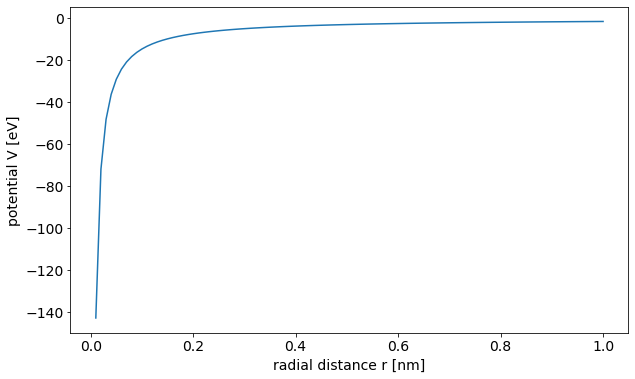

In [4]:
### TASK 1 plot
def potential_numerical(r, alpha):
    def force(r, alpha):
        return -c2*np.power(r,-2+alpha)*np.power(r0,-alpha)

    val, err=integrate.quad(force,r,np.inf,args=alpha)
    return val

N = 100
rmax = 1
dr = rmax / N
r = np.arange(1, N+1) * dr
v = np.array([potential_numerical(my_r, 0.01) for my_r in r])
plt.plot(r, v)
plt.xlabel('radial distance r [nm]')
plt.ylabel('potential V [eV]')
plt.show()

## Task 2

In addition to (1), the test below will compare the analytic expression for V(r) with the numerically obtained values for r = 0.01,0.02...1 nm. The biggest absolute difference diff = max |V_{exact}(r) − V_{numerical}(r)| must be smaller than 1e-5 eV. There is nothing else for you to do.

In [5]:
### TASK 2 marking cell

def _potential_exact(r, alpha):
    return c2*np.power(r,-1+alpha)*np.power(r0,-alpha)/(-1+alpha)

for my_r in np.linspace(0.01, 1, 100):
    diff = abs(potential_numerical(my_r, 0.01) - _potential_exact(my_r, 0.01))
    assert(diff <= 1e-5)

## Task 3

In addition to (2), calculate the first 2 energy levels (eigenvalues of H) for \alpha = 0, 0.01 and print out the values in eV. The values must be accurate to 0.01 eV. This requires sufficiently large r_{max} and N. Plot the difference \Delta E between the two energies for \alpha = 0, 0.01. Remember to label the axes.

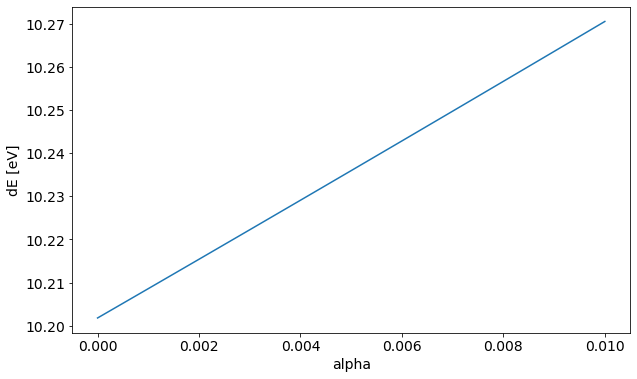

In [6]:
### TASK 3 plot
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags

def _energy_levels(alpha, N):
    rmax = 1.5 # this value has been found experimentally to give a good tradeoff between speed and accuracy

    r = rmax * np.linspace(1/N, 1, N)
    dr = rmax / N

    diagonals = [np.full((N),  -2),
                 np.full((N-1), 1),
                 np.full((N-1), 1)]
    delta = diags(diagonals, [0, -1, 1])

    diagonals = (c2*r**(-1 + alpha)*(1/r0)**alpha)/(-1 + alpha)
    V = diags(diagonals)

    H = -c1 * delta / dr**2 + V

    vv, ww = eigsh(H, min(20, N-2), which="SM")    # we will use a method for sparse hermitian matrices here
                                                # this is fast enough. But a better method exist that we will use later
    E = np.sort(np.real(vv))
    E1 = E[0]
    E2 = E[1]

    return E1, E2

def energy_levels(alpha):
    E1, E2 = _energy_levels(alpha, 1024)
    return E1, E2

### TASK 3
alpha = np.linspace(0, 0.01, 11)
dE = []
for my_alpha in alpha:
    E1, E2 = energy_levels(my_alpha)
    dE.append(E2-E1)
plt.plot(alpha, dE)
plt.xlabel('alpha')
plt.ylabel('dE [eV]')
plt.show()

In [8]:
### TASK 3 marking cell

## the "correct" energy levels
_e_correct = {0:    (-13.605693122994, -13.605693122994/4),
              0.01: (-13.807387841665346, -3.5346025272551795)}

def _compare_el(alpha, tol, e_test):
    e_c = _e_correct[alpha]
    for my_ec, my_et in zip(e_c, e_test):
        print(f"alpha: {alpha:.2f}, E(correct): {my_ec:.6f}, E(student): {my_et:.6f}, diff: {abs(my_ec - my_et):.6f}, tol: {tol}.")
        assert(abs(my_ec - my_et) <= tol)

# Print out the energy levels for alpha = 0, 0.01.
e_levels_0 = energy_levels(0.0)
e_levels_0_01 = energy_levels(0.01)
print ("alpha = 0.00:", e_levels_0)
print ("alpha = 0.01:", e_levels_0_01)

_e_test = {0: e_levels_0,
           0.01: e_levels_0_01}
tol = 0.01
for my_alpha in [0, 0.01]:
    _compare_el(my_alpha, tol, _e_test[my_alpha])

alpha = 0.00: (-13.603009365111914, -3.401240417909124)
alpha = 0.01: (-13.805103845839614, -3.5344766180666727)
alpha: 0.00, E(correct): -13.605693, E(student): -13.603009, diff: 0.002684, tol: 0.01.
alpha: 0.00, E(correct): -3.401423, E(student): -3.401240, diff: 0.000183, tol: 0.01.
alpha: 0.01, E(correct): -13.807388, E(student): -13.805104, diff: 0.002284, tol: 0.01.
alpha: 0.01, E(correct): -3.534603, E(student): -3.534477, diff: 0.000126, tol: 0.01.


## Task 4

In addition to (3), assuming that the transition between the 1st excited and the ground state corresponds to the wavelength lambda = 121.5 \pm 0.1 nm, what is the maximum value of alpha_{max} > 0 consistent with this measurement (i.e., the largest alpha_{max} > 0 such that the predicted and measured wavelengths differ by less than 0.1 nm)?

In [9]:
### TASK 4

import scipy.optimize as opt

def wavelength(alpha):
    e0, e1 = energy_levels(alpha)
    return hc / (e1-e0) # in nm

def diff_wavelength(alpha):
    diff = 121.5 - 0.1 - wavelength(alpha) # in nm
    return diff

def find_alpha_max():
    alpha_max = opt.brentq(diff_wavelength, 0, 0.01)
    return alpha_max

In [10]:
### TASK 4 marking cell

# Run the function and print alpha_max.
alpha_max = find_alpha_max()
print ("alpha_max:", alpha_max)

_alpha_max_correct = 0.0016279327237692773
assert(((alpha_max / _alpha_max_correct) <= 2) and
       ((alpha_max / _alpha_max_correct) >= 0.5))

alpha_max: 0.0016279327230272736


## Task 5

Improve the accuracy of the computation of the two energy levels to 0.001 eV and find alpha_{max} assuming the wavelength lambda = 121.503 \pm 0.01 nm.

In [11]:
### TASK 5

# we will use a slightly different diagonalization method that will enable us to get the higher accuracy originally
# demanded in the checkpoint (0.0001eV), while not being much slower (since much larger N is required)

import scipy.optimize as opt
from scipy.linalg import eigh_tridiagonal

def _energy_levels_improved_raw(alpha,N):
    rmax = 1.5 # this value has been found experimentally to give a good tradeoff between speed and accuracy

    r = rmax * np.linspace(1/N, 1, N)
    dr = rmax / N

    potential = (c2*r**(-1 + alpha)*(1/r0)**alpha)/(-1 + alpha)
    diagonal = -(c1/dr**2)*np.full((N), -2) + potential
    offdiag = -(c1/dr**2)*np.full((N-1), 1)
    
    vv, ww = eigh_tridiagonal(diagonal, offdiag, select='i', select_range=[0,1])

    E = np.sort(np.real(vv))
    E1 = E[0]
    E2 = E[1]

    return E1, E2

def wavelength_improved(alpha):
    e0, e1 = _energy_levels_improved_raw(alpha, 15000)
    return hc / (e1-e0) # in nm

def diff_wavelength_improved(alpha):
    diff = 121.503 - 0.01 - wavelength_improved(alpha) # in nm
    return diff

def energy_levels_improved(alpha):
    E1, E2 = _energy_levels_improved_raw(alpha, 15000) # now we need a much larger N
    return E1, E2

def find_alpha_max_improved():
    alpha_max = opt.brentq(diff_wavelength_improved, 0, 0.01)
    return alpha_max

In [12]:
### TASK 5 marking cell

# Run the function and print alpha_max.
e_levels_0_01 = energy_levels_improved(0.01)
print ("alpha = 0.01:", e_levels_0_01)

tol = 0.001
_compare_el(0.01, tol, e_levels_0_01)

# Run the function and print alpha_max.
alpha_max_improved = find_alpha_max_improved()
print ("alpha_max:", alpha_max_improved)

_alpha_max_correct_improved = 0.0001291010283870315
assert(((alpha_max_improved / _alpha_max_correct_improved) <= 2) and
       ((alpha_max_improved / _alpha_max_correct_improved) >= 0.5))

alpha = 0.01: (-13.807386221625073, -3.5346024455156178)
alpha: 0.01, E(correct): -13.807388, E(student): -13.807386, diff: 0.000002, tol: 0.001.
alpha: 0.01, E(correct): -3.534603, E(student): -3.534602, diff: 0.000000, tol: 0.001.
alpha_max: 0.00012515572787387131


## Task 6

How would one achieve the accuracy 0.0001eV with significantly smaller matrices? Hint: can we represent R from Eq. (1) as a linear combination of functions that solve the "unperturbed" equation, and translate this into an eigenproblem for a certain N \times N matrix, with N < 100?

### Possible solution

I wanted you to be creative in this task. The task can be solved in many different ways. Below is one of them based on the observation that the original Schroedinger equation is just a linear equation for a certain linear operator, and hence it admits many different matrix representations. One of them (wave functions represented as linear combinations of delta-like functions in the real space) was used to construct tridiagonal matrices from tasks 1-5. Another way is to approximate the eigenvectors of the Hamiltonian by a linear combinations of orthogonal functions on [0,infty]. This leads to significantly smaller matrices because fewer such functions are required to accurately represent eigenvectors of H. However, the price to pay is that the matrix is dense and matrix elements must be evaluated numerically. This method has been implemented below. The solution does not require the knowledge of quantum mechanics (linear algebra concepts such as change of basis, orthogonal sets of base vectors should be sufficient) but if you have ever heard about the Variational Method, this solution is related to that method.

A slightly similar method (used by one of your colleagues) which does require a bit of quantum mechanics background is to treat the new potential as a "perturbation" of the Coulomb potential. This method does not require any matrix diagnoalization at all.

In [145]:
### TASK 6

# this solves the problem to the original accuracy 0.0001eV

import scipy.optimize as opt
import scipy.special as sp

# For this we need orthogonal functions on 0..infty. A quick search (Wikipedia) shows that 
# Laguerre polynomials multiplied by exp(-x/2) have the required property
# These functions will be our new basis in which we will represent eigenvectors of the Hamiltonian

# this function generates matrix elements between two base functions with indices n,m, and the potential V(r)
# the potential is non-dimensionalized here for simplicity
def fn(x, n, m, alpha):
    return sp.eval_laguerre(n,x) * (1/x) * (1/(1-alpha)) * \
        ((x/2)**alpha) * sp.eval_laguerre(m,x) * np.exp(-x)

def wavelength_best(alpha):
    e0, e1 = energy_levels_best(alpha)
    return hc / (e1-e0) # in nm

def diff_wavelength_best(alpha):
    diff = 121.503 - 0.001 - wavelength_best(alpha) # in nm
    return diff

def energy_levels_best(alpha):

    nn=50 # this size of the matrix is enough to get to 0.0001eV
    hh=np.empty([nn,nn])
    minhh=1e6
    # calculation of the elements of the Hamiltonian matrix
    # we could have done it using the full Hamiltonian, but it is a bit faster to explore some symmetries
    # and properties of our base functions,
    # hence the "cryptic" values, m, n 0.5, -0.75 etc in the expression below:
    for n in range(0,nn):
        for m in range(0,nn):
            #print(n," ",m," ",end="")
            # in the following we use two different integration limits below and above m,n=45 because
            # the quad function's adaptive integration does not seem to work properly for a highly-peaked fn
            # for n,m>45 when the upper limit is np.infty
            if n<45 and m<45:
                val, err=integrate.quad(fn,1e-6,np.infty,args=(n,m,alpha),epsabs=1e-12,limit=100)
            else:
                val, err=integrate.quad(fn,1e-6,1000,args=(n,m,alpha),epsabs=1e-12,limit=100)
            #print(val)
            hh[n,m]=-val-m+0.5
            if n==m:
                hh[n,m]+=n-0.75
            else:
                hh[n,m]+=min(n,m)-0.5  
            if hh[n,m]<minhh: minhh=hh[n,m]
    hh-=minhh
    v, w = np.linalg.eig(hh) # now since the matrix is small we do not have to try very hard to diagonalize it
                            # so we can do it using the most general routine
    E=np.sort(v)*(c2**2)/c1  # rescale the values to get correct units (eV)
    E1 = E[0]
    E2 = E[1]

    return E1, E2

def find_alpha_max_best():
    alpha_max = opt.brentq(diff_wavelength_best, 0, 0.01)
    return alpha_max

In [146]:
### TASK 6 marking cell

# Run the function and print alpha_max.
e_levels_0_01 = energy_levels_best(0.01)
print ("alpha = 0.01:", e_levels_0_01)

tol = 0.0001
_compare_el(0.01, tol, e_levels_0_01)

# Run the function and print alpha_max.
alpha_max_best = find_alpha_max_best()
print ("alpha_max:", alpha_max_best)

alpha = 0.01: (-13.807288943953521, -3.53458949377518)
alpha: 0.01, E(correct): -13.807388, E(student): -13.807289, diff: 0.000099, tol: 0.0001.
alpha: 0.01, E(correct): -3.534603, E(student): -3.534589, diff: 0.000013, tol: 0.0001.
alpha_max: 1.2055081239240464e-05
